In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import pickle

import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials


## Load Music Data

In [2]:
artname = pd.read_csv('data/usersha1-artmbid-artname-plays.tsv', sep='\t', header=None, names = ['users', 'artist_id', 'artist_name', 'plays'],
                        usecols = ['users', 'artist_name', 'plays'])
profile = pd.read_csv('data/usersha1-profile.tsv', sep='\t', header=None, names = ['users', 'gender', 'age', 'country', 'sign_up'],
                        usecols = ['users', 'country'])


In [3]:
#Getting all the spotify_data follwing by numbers
filenames = glob.glob('data/spotify_data*.csv')
l = []
for file in filenames: 
    df = pd.read_csv(file)
    l.append(df)
    
spotify_data = pd.concat(l, axis = 0,ignore_index= True)
spotify_data.head()

,trackid,artist_name,track_name,pid
0,spotify:track:2vCtiBvJJZfz773yTfAxPP,Lost Frequencies,What Is Love 2016 - Mike Mago Remix,3000
1,spotify:track:5WOLZP8KrXiupBjG1SSN5U,John Legend,Love Me Now - Dave Audé Remix Radio Edit,3000
2,spotify:track:0oQDQ9QiqsO63EEBAro8Le,July Child,Thinkin of U,3000
3,spotify:track:7MUS0La2IQ85vJ59fQqtoN,Tiësto,I Will Be Here - (Wolfgang Gartner Remix),3000
4,spotify:track:3ciyZYofjiqmMUElM5qgGB,Joe Stone,The Party (This Is How We Do It),3000


In [4]:
#SpotifyClientCredentials that can be used to authenticate requests like
#Using Spotify API to collect more detailed audio features
client_credentials_manager = SpotifyClientCredentials(client_id="ad1a53bb434c4023a44d59b0c5ac533b",client_secret='e25b1aa4183d47b7abb9c0494bb05696')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)



In [5]:
trackid = list(set(spotify_data.trackid))
audio_features = []
popularity1 = []

In [6]:
#Since sp.audio_features only works for hundreds of elements, separated trackid into blocks and then applied the function
# for i, group in enumerate(zip_longest(*(iter(trackid),) * 100)):
#     group = list(filter(None, group))
#     audio_features.append(pd.DataFrame(sp.audio_features(tracks=group))) 


In [7]:
features = []
popularity = []
uri = []
batchsize = 50
none_count = 0
none_count2 = 0
for i in range(0,len(trackid),batchsize):
    batch = trackid[i:i+batchsize]
    track_results = sp.tracks(batch)
    features_results = sp.audio_features(tracks = batch)
    for i, t in enumerate(track_results['tracks']):
        if t == None:
            none_count += none_count + 1
        else:
            popularity.append(t['popularity'])
            uri.append(t['uri'])
    for i, t in enumerate(features_results):
        if t == None:
            none_count2 += none_count2 + 1
        else:
            features.append(t)

In [8]:
features = pd.DataFrame.from_dict(features)
features = features.drop(['id','analysis_url','type','track_href','type'], axis = 1)
features = features.set_index("uri")
df_pop = pd.DataFrame(
    {'uri': uri,
     'popularity': popularity
    })
df_pop = df_pop.set_index("uri")


In [9]:
all_features = pd.merge(features,df_pop, left_index=True, right_index=True)
all_features.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
uri,,,,,,,,,,,,,,
spotify:track:5t0qHDRcCcrcAFylsEeyG5,0.729000,0.545,296253,0.470,0.015700,4,0.1390,-9.338,0,0.2200,194.082,4,0.5750,0
spotify:track:20tiyvXaJMmnLCnStJY3s5,0.163000,0.565,248760,0.893,0.006580,7,0.8330,-9.374,1,0.0433,131.880,4,0.5540,28
spotify:track:311vr5Ga7G9YN7vbZWXgyb,0.016300,0.768,230960,0.431,0.000248,4,0.0828,-14.467,0,0.1250,171.835,4,0.7910,31
spotify:track:6wrEnhx4sw0USAzbpWNiuH,0.117000,0.562,227000,0.784,0.000047,3,0.0931,-5.783,1,0.0261,104.987,4,0.5190,38
spotify:track:7t7SLzJtQzD8wdJqwYD3XM,0.000034,0.517,235861,0.660,0.252000,5,0.5710,-6.175,0,0.0315,90.007,4,0.0701,54


In [56]:
pickle.dump(all_features, open( "all_features.p", "wb" ) )
#features = pickle.load( open( "save.p", "rb" ) )b

In [3]:
all_features = pickle.load(open("all_features.p","rb"))
all_features.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
uri,,,,,,,,,,,,,,
spotify:track:5t0qHDRcCcrcAFylsEeyG5,0.729000,0.545,296253,0.470,0.015700,4,0.1390,-9.338,0,0.2200,194.082,4,0.5750,0
spotify:track:20tiyvXaJMmnLCnStJY3s5,0.163000,0.565,248760,0.893,0.006580,7,0.8330,-9.374,1,0.0433,131.880,4,0.5540,28
spotify:track:311vr5Ga7G9YN7vbZWXgyb,0.016300,0.768,230960,0.431,0.000248,4,0.0828,-14.467,0,0.1250,171.835,4,0.7910,31
spotify:track:6wrEnhx4sw0USAzbpWNiuH,0.117000,0.562,227000,0.784,0.000047,3,0.0931,-5.783,1,0.0261,104.987,4,0.5190,38
spotify:track:7t7SLzJtQzD8wdJqwYD3XM,0.000034,0.517,235861,0.660,0.252000,5,0.5710,-6.175,0,0.0315,90.007,4,0.0701,54


In [10]:
spotify_data = spotify_data.set_index('trackid')


In [11]:
merged = pd.merge(all_features,spotify_data, left_index=True, right_index=True) # Merging Two dataframes based on their indexes to combine all the information.
merged = merged[~merged.index.duplicated(keep='first')] #Dropping duplicated index.


In [12]:
merged['artist_name'] = merged['artist_name'].astype(str).str.lower()

In [13]:
merged.info()
merged.sort_values(['artist_name','track_name'],inplace=True)
merged.head()

<class 'pandas.core.frame.DataFrame'>
Index: 93132 entries, spotify:track:000VZqvXwT0YNqKk7iG2GS to spotify:track:7zzLt6Z9y7jMvXnEg00n58
Data columns (total 17 columns):
acousticness        93132 non-null float64
danceability        93132 non-null float64
duration_ms         93132 non-null int64
energy              93132 non-null float64
instrumentalness    93132 non-null float64
key                 93132 non-null int64
liveness            93132 non-null float64
loudness            93132 non-null float64
mode                93132 non-null int64
speechiness         93132 non-null float64
tempo               93132 non-null float64
time_signature      93132 non-null int64
valence             93132 non-null float64
popularity          93132 non-null int64
artist_name         93132 non-null object
track_name          93132 non-null object
pid                 93132 non-null int64
dtypes: float64(9), int64(6), object(2)
memory usage: 12.8+ MB


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,artist_name,track_name,pid
spotify:track:7y8aVfDkqt6qirGNivvs0M,0.00255,0.702,243627,0.851,0.000059,10,0.3220,-5.747,0,0.0407,117.004,4,0.870,51,!!!,One Girl / One Boy,3785
spotify:track:32TXsOUIWtTQDkE72Cvafe,0.00232,0.711,351093,0.893,0.196000,9,0.6420,-6.059,1,0.0781,120.751,4,0.629,41,!!!,Pardon My Freedom,2997
spotify:track:0BjOgTLP0kLC88XqMoyrv8,0.06260,0.858,254920,0.717,0.243000,0,0.2160,-8.734,1,0.0995,120.004,4,0.582,39,!!!,Slyd,2871
spotify:track:5zfg3qZOcjS4IFhazNk9PW,0.03640,0.694,313093,0.798,0.024000,2,0.0596,-6.010,1,0.0725,126.073,4,0.456,38,!!!,Yadnus,1633
spotify:track:3MZ0Obyv6AnO1anmGBJydv,0.09200,0.805,48387,0.414,0.719000,1,0.0723,-10.608,0,0.5160,161.707,4,0.527,40,!llmind,Take A Break - Interlude,3162


In [31]:
def heatMap(df):
    """ Taking a dataframe and returns to Heat Map to describe 
        each of features in the df.
    """
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(10, 10))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map based on Correlation
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

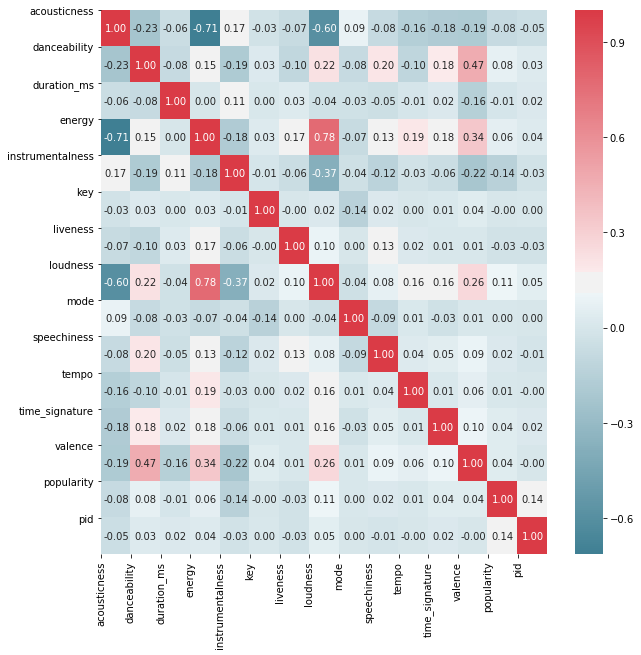

In [32]:
heatMap(merged)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity,pid
acousticness,1.000000,-0.226186,-0.060534,-0.713778,0.174851,-0.026075,-0.071380,-0.596412,0.086293,-0.078569,-0.160008,-0.178988,-0.188732,-0.082986,-0.052544
danceability,-0.226186,1.000000,-0.081051,0.154057,-0.190652,0.025915,-0.104319,0.222941,-0.083933,0.197259,-0.104809,0.181671,0.469680,0.076009,0.034961
duration_ms,-0.060534,-0.081051,1.000000,0.001413,0.112467,0.004935,0.030161,-0.036888,-0.033436,-0.045616,-0.009392,0.021644,-0.157147,-0.005996,0.020610
energy,-0.713778,0.154057,0.001413,1.000000,-0.182673,0.030126,0.173217,0.776466,-0.073344,0.126107,0.194946,0.175431,0.337841,0.057986,0.035594
instrumentalness,0.174851,-0.190652,0.112467,-0.182673,1.000000,-0.007824,-0.061498,-0.373839,-0.042831,-0.124674,-0.029090,-0.060529,-0.222073,-0.139588,-0.028118
key,-0.026075,0.025915,0.004935,0.030126,-0.007824,1.000000,-0.001168,0.018966,-0.142933,0.021540,0.000528,0.012186,0.038244,-0.002881,0.003953
liveness,-0.071380,-0.104319,0.030161,0.173217,-0.061498,-0.001168,1.000000,0.095845,0.000792,0.133249,0.016858,0.006116,0.009132,-0.025709,-0.027530
loudness,-0.596412,0.222941,-0.036888,0.776466,-0.373839,0.018966,0.095845,1.000000,-0.038356,0.075170,0.162379,0.157913,0.258119,0.108964,0.050073
mode,0.086293,-0.083933,-0.033436,-0.073344,-0.042831,-0.142933,0.000792,-0.038356,1.000000,-0.090172,0.010772,-0.032611,0.005344,0.004284,0.000269
speechiness,-0.078569,0.197259,-0.045616,0.126107,-0.124674,0.021540,0.133249,0.075170,-0.090172,1.000000,0.035129,0.045935,0.090605,0.018396,-0.012348


As we can see from the heat map, energy and loudness are negativley correlated with acousticness.
Energy and loudness,

In [16]:
artname = artname.set_index('users')
profile = profile.set_index('users')

In [35]:
profile_merged = pd.merge(artname,profile, left_index=True, right_index=True)
profile_merged = profile_merged.reset_index()

In [42]:
profile_merged.groupby(['artist_name'])['plays'].sum().describe()

count    2.923630e+05
mean     1.290700e+04
std      1.859815e+05
min      1.000000e+00
25%      5.300000e+01
50%      2.080000e+02
75%      1.048000e+03
max      3.046683e+07
Name: plays, dtype: float64

There was a huge difference between minimum plays and maximum plays. Hence, I would like to exclude some data points to prevent the noise.

In [53]:
artists_plays = profile_merged.groupby(['artist_name'])['plays'].sum().reset_index()
artists_plays.columns = ['artist_name','total plays']
artists_plays.head()

,artist_name,total plays
0,04)],6
1,2,1606
2,58725ab=>,23
3,80lİ yillarin tÜrkÇe sÖzlÜ aŞk Şarkilari,70
4,amy winehouse,23


In [54]:
artists_merged = artname.merge(artists_plays, on='artist_name', how ='left')
artists_merged.head()

,artist_name,plays,total plays
0,betty blowtorch,2137,25651.0
1,die Ärzte,1099,3704875.0
2,melissa etheridge,897,180391.0
3,elvenking,717,410725.0
4,juliette & the licks,706,90498.0


In [19]:
has_nan = profile_merged.isnull().any(axis=0)
has_nan = [profile_merged.columns[i] for i in np.where(has_nan)[0]]

print(has_nan)

['artist_name']


In [1]:
total = pd.merge(profile_merged,merged, on='artist_name', how='left')

NameError: name 'pd' is not defined

How to connect KNN two matrix. 
1. profile and artist_name --> Will recommend artist based on the number of plays. Collarborative Filtering
2. songs and features --> will recommend songs. Content Based Filters.

Get average of each features for unique artists and then apply knn to get similar artist based on features?
